In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
aexdf = pd.read_csv("data_aex.csv", sep=";")
aexdf["Date"] = pd.to_datetime(aexdf["Date"])
aexdf["YearMonth"] = aexdf["Date"].dt.to_period("M")

aexdf = aexdf.sort_values(by=["ticker"])

aexdf["Monthly_Return"] = aexdf.groupby("ticker")["Adj Close"].pct_change()
aexdf["Momentum"] = aexdf.groupby("ticker")["Adj Close"].shift(1) / aexdf.groupby("ticker")["Adj Close"].shift(12) - 1

aexdf["Zero_Return"] = (aexdf["Monthly_Return"] == 0).astype(int)
aexdf["Zero_Streak"] = aexdf.groupby("ticker")["Zero_Return"].cumsum() * aexdf["Zero_Return"]
tickers_with_zero_returns = aexdf[aexdf["Zero_Streak"] > 1]["ticker"].unique()
print(tickers_with_zero_returns)

#filter wolters kluwer
print(aexdf[aexdf["Zero_Streak"] == 2])
filtered_df = aexdf[aexdf["Zero_Streak"] <= 1].drop(columns=["Zero_Return", "Zero_Streak"])
filtered_df = filtered_df.reset_index(drop=True)

# print(filtered_df[filtered_df["Zero_Streak"] > 1]["ticker"].unique())
print(aexdf[["ticker", "Date", "Adj Close", "Close", "Open"]][aexdf["Close"] == aexdf["Open"]])

# print(aexdf[["Date", "ticker", "Adj Close", "Monthly_Return", "Momentum"]].head(20))

[]
Empty DataFrame
Columns: [Date, Adj Close, Close, High, Low, Open, Volume, ticker, YearMonth, Monthly_Return, Momentum, Zero_Return, Zero_Streak]
Index: []
        ticker       Date  Adj Close      Close       Open
43      ABN.AS 2019-06-01  11.786198  18.815001  18.815001
663    AKZA.AS 2018-11-01  59.374126  83.362488  83.362488
1543   HEIA.AS 2018-04-01  77.088051  87.300003  87.300003
3079  SHELL.AS 2013-03-01  12.994920  25.190001  25.190001


High Momentum Tickers: ['PHIA.AS', 'PRX.AS', 'INGA.AS', 'AD.AS', 'UNA.AS', 'WKL.AS', 'REN.AS', 'AGN.AS']
Low Momentum Tickers: ['BESI.AS', 'HEIA.AS', 'ASML.AS', 'AKZA.AS', 'RAND.AS', 'EXO.AS', 'UMG.AS', 'ASM.AS']


/tmp/ipykernel_5934/1350419639.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  momentum_df['YearMonth'] = pd.to_datetime(momentum_df['YearMonth'], errors='coerce')
/tmp/ipykernel_5934/1350419639.py:66: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.gca().set_xticks(mdates.date2num(momentum_df['YearMonth'].dt.to_pydatetime())[::12])  # Show one tick per year


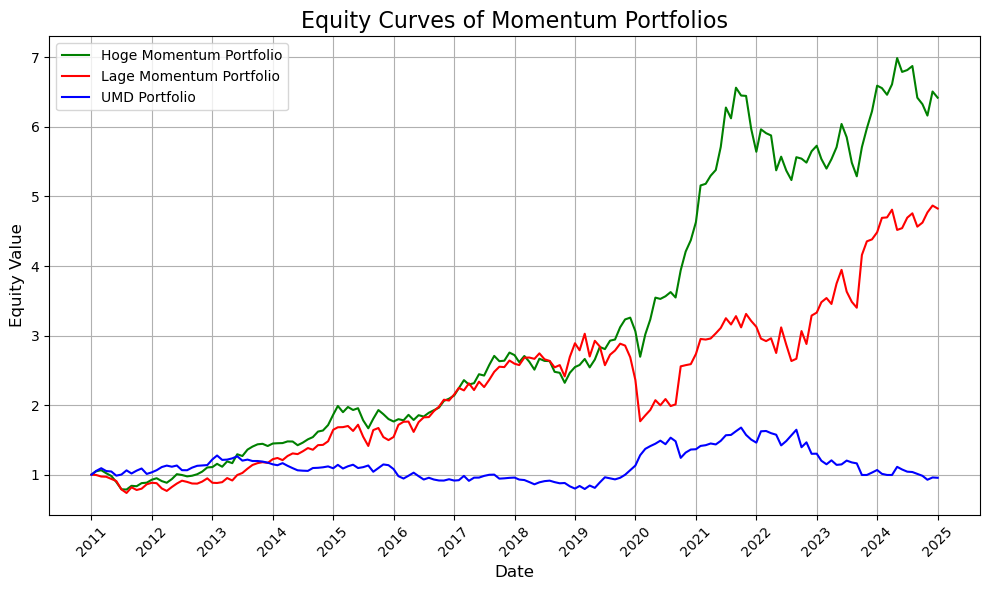

In [ ]:
aexdf["Date"] = pd.to_datetime(aexdf["Date"])
aexdf["YearMonth"] = aexdf["Date"].dt.to_period("M")

aexdf = aexdf.sort_values(by=["ticker", "Date"])

aexdf["Monthly_Return"] = aexdf.groupby("ticker")["Adj Close"].pct_change()

# creeer een momentum kolom
aexdf["Momentum"] = aexdf.groupby("ticker")["Adj Close"].shift(1) / aexdf.groupby("ticker")["Adj Close"].shift(12) - 1

aexdf = aexdf[aexdf["YearMonth"] >= "2011-02"]

portfolio_returns = []

last_month = aexdf["YearMonth"].max()
for month, group in aexdf.groupby("YearMonth"):
    group = group.dropna(subset=["Momentum"]) # Drop NaNs 

    # de acht hoogste en laagste values voor momentum per maand
    high_mom = group.nlargest(8, "Momentum")
    low_mom = group.nsmallest(8, "Momentum")

    # vraag 3 G
    if month == last_month:
        print("High Momentum Tickers:", high_mom["ticker"].tolist())
        print("Low Momentum Tickers:", low_mom["ticker"].tolist())

    # ga ervan uit dat alle 8 hoogste en laagste allemaal dezelfde waarde in de portefeuille krijgen
    high_return = high_mom["Monthly_Return"].mean()
    low_return = low_mom["Monthly_Return"].mean()
    umd_return = high_return - low_return

    portfolio_returns.append([month, high_return, low_return, umd_return])

momentum_df = pd.DataFrame(portfolio_returns, columns=["YearMonth", "High_Momentum_Return", "Low_Momentum_Return", "UMD_Return"])

# beetje getover anders komt er op de x axis in de grafiek alle data per maand te staan
momentum_df["YearMonth"] = momentum_df["YearMonth"].astype(str)
momentum_df["YearMonth"] = pd.to_datetime(momentum_df["YearMonth"], errors="coerce")

# equity curves
momentum_df["High_Momentum_Equity"] = (1 + momentum_df["High_Momentum_Return"]).cumprod()
momentum_df["Low_Momentum_Equity"] = (1 + momentum_df["Low_Momentum_Return"]).cumprod()
momentum_df["UMD_Equity"] = (1 + momentum_df["UMD_Return"]).cumprod()

# Normaliseer naar 1 op begin datum dus iloc(0)
momentum_df.iloc[0, momentum_df.columns.get_loc("High_Momentum_Equity")] = 1
momentum_df.iloc[0, momentum_df.columns.get_loc("Low_Momentum_Equity")] = 1
momentum_df.iloc[0, momentum_df.columns.get_loc("UMD_Equity")] = 1

# zet de rendementen in de grafiek
plt.figure(figsize=(10, 6))
plt.plot(momentum_df["YearMonth"], momentum_df["High_Momentum_Equity"], label="Hoge Momentum Portfolio", color="green")
plt.plot(momentum_df["YearMonth"], momentum_df["Low_Momentum_Equity"], label="Lage Momentum Portfolio", color="red")
plt.plot(momentum_df["YearMonth"], momentum_df["UMD_Equity"], label="UMD Portfolio", color="blue")

# grafieken
plt.title("Equity Curves van de Momentum Portfolios", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Equity Value", fontsize=12)
plt.legend(loc="upper left")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # x axis in jaren
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.gca().set_xticks(mdates.date2num(momentum_df["YearMonth"].dt.to_pydatetime())[::12])  # Show one tick per year
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# vraag 3 G
De tickers in de hoge momentum portfolio te maart 2025 zijn: 'PHIA.AS', 'PRX.AS', 'INGA.AS', 'AD.AS', 'UNA.AS', 'WKL.AS', 'REN.AS', 'AGN.AS'  
De tickers in de laag momentum porftolio te maart 2025 zijn: 'BESI.AS', 'HEIA.AS', 'ASML.AS', 'AKZA.AS', 'RAND.AS', 'EXO.AS', 'UMG.AS', 'ASM.AS'

In [ ]:
high_momentum_mean = momentum_df["High_Momentum_Return"].mean()
high_momentum_std = momentum_df["High_Momentum_Return"].std()

low_momentum_mean = momentum_df["Low_Momentum_Return"].mean()
low_momentum_std = momentum_df["Low_Momentum_Return"].std()

umd_mean = momentum_df["UMD_Return"].mean()
umd_std = momentum_df["UMD_Return"].std()

# print(high_momentum_std, low_momentum_std, umd_std)

# Vraag 3D sharpe ratios
high_momentum_sharpe = high_momentum_mean / high_momentum_std
low_momentum_sharpe = low_momentum_mean / low_momentum_std
umd_sharpe = umd_mean / umd_std

# floats tot 5 decimalen
print(f"Hoge Momentum Portfolio Sharpe Ratio: {high_momentum_sharpe:.5f}")
print(f"Lage Momentum Portfolio Sharpe Ratio: {low_momentum_sharpe:.5f}")
print(f"Hoog min laag Portfolio Sharpe Ratio: {umd_sharpe:.5f}")

High-Momentum Portfolio Sharpe Ratio: 0.26530
Low-Momentum Portfolio Sharpe Ratio: 0.18142
UMD Portfolio Sharpe Ratio: 0.01784


# vraag 3 D
Portfolio High heeft de hoogste sharpe ratio. high minus low heeft de laagste sharpe ratio.

In [ ]:
#gebruikt msci data van WRDS erasmus database dit hoort nog bij vraag 3A
msci_df = pd.read_csv("./msci.csv")
msci_df = msci_df.drop(columns=["_DMIEU0D-volume"])  
msci_df["DateMSCI"] = pd.to_datetime(msci_df["Date"]) 
msci_df["DateMSCI"] = (msci_df["DateMSCI"] + pd.DateOffset(months=1)).apply(lambda x: x.replace(day=1))
# print(msci_df["DateMSCI"].head(), momentum_df["YearMonth"].head())
msci_df["ReturnMSCI"] = msci_df["_DMIEU0D-close"].pct_change()

momentum_df = momentum_df.merge(msci_df[["DateMSCI","ReturnMSCI"]], left_on="YearMonth", right_on="DateMSCI", how="left")

# momentum_df.head()
momentum_df["Constant"] = 1

In [ ]:
import statsmodels.api as sm

X_high = momentum_df[["Constant", "ReturnMSCI"]]
y_high = momentum_df["High_Momentum_Return"] 
model_high = sm.OLS(y_high, X_high).fit()
y_low = momentum_df["Low_Momentum_Return"] 
model_low = sm.OLS(y_low, X_high).fit()
y_umd = momentum_df["UMD_Return"] 
model_umd = sm.OLS(y_umd, X_high).fit()

print("Hoge Momentum Portfolio regressie resultaten:")
print(model_high.summary())
print("\nLow-Momentum Portfolio regressie resultaten:")
print(model_low.summary())
print("\nUMD Portfolio regressie resultaten:")
print(model_umd.summary())

high_momentum_alpha, high_momentum_beta = model_high.params["Constant"], model_high.params["ReturnMSCI"]
low_momentum_alpha, low_momentum_beta = model_low.params["Constant"], model_low.params["ReturnMSCI"]
umd_alpha, umd_beta = model_umd.params["Constant"], model_umd.params["ReturnMSCI"]

print("\nAlphas en Betas:")
print(f"HOge Momentum Portfolio Alpha: = {high_momentum_alpha:.4f} Beta = {high_momentum_beta:.4f}")
print(f"Lage Momentum Portfolio Alpha = {low_momentum_alpha:.4f} Beta = {low_momentum_beta:.4f}")
print(f"Hoog min laag Portfolio: Alpha = {umd_alpha:.4f}, Beta = {umd_beta:.4f}")

Hoge Momentum Portfolio regressie resultaten:
                             OLS Regression Results                             
Dep. Variable:     High_Momentum_Return   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.006
Method:                   Least Squares   F-statistic:                   0.08000
Date:                  Sat, 29 Mar 2025   Prob (F-statistic):              0.778
Time:                          22:54:54   Log-Likelihood:                 282.67
No. Observations:                   169   AIC:                            -561.3
Df Residuals:                       167   BIC:                            -555.1
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

# Vraag 3 E en F
High momentum portfolio heeft minder alpha dan de low momentum portfolio aangezien 0.0122 > 0.0120. De hoge momentum portfolio zorgt dus voor lagere returns ten opzichte van de markt dan de lage momentum portfolio.  
Low momentum portfolio heeft een beta van -0.1451 wat negatief is en lager is dan de beta van de high momentum portfolio waar de beta 0.0207 is. Dit betekent dat de lage momentum portfolio negatief aan de marktbeweging is gecorreleerd dan de hoge momentum portfolio positief aan de markt is gecorreleerd.    
De beta van de hoog min laag portfolio is 0.1659 wat betekend dat deze portfolio zich met de markt mee beweegt.    
Alleen de t-statistieken van de high en low portfolio zijn significant (t > 1.96). Wat betekent dat we niet zeker kunnen zijn of de umd portfolio wel alpha genereert. Alpha van UMD is -.0002